In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

In [2]:
data = pd.read_csv('house-prices.csv')

# Data Preparation

In [3]:
data.dropna(thresh = 2300, axis = 1, inplace = True)
data.drop(['Order', 'Mas Vnr Area', 'BsmtFin Type 2', 'BsmtFin SF 2', 'Mo Sold', 'Sale Type',
           '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'Low Qual Fin SF', 'Yr Sold', 
           'Enclosed Porch', 'Year Remod/Add', 'Bsmt Unf SF', '2nd Flr SF', 'Bsmt Half Bath']
          , axis = 1, inplace = True)
data.set_index('PID', inplace = True)
columns_missing_values = ['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'Mas Vnr Type']
for column in columns_missing_values :
    data[column].fillna(value = 'None', inplace = True)
data['Electrical'].fillna(value = 'SBrkr', inplace = True)
data.fillna(0, inplace = True)
data['LogSalePrice'] = np.log10(data['SalePrice'])
data['LogLotArea'] = np.log10(data['Lot Area'])

We dropped the columns that did not seem useful for our purposes (like the Order number or the year of the sale). In addition, we dropped the columns that had a lot of null-values or too much zeroes. We filled the remaining null-values in the columns by 'None' or zeroes, depending of the data type. Another potential problem we have is that some of the columns are quasi-colinear. For example, 'Gr Liv Area' = '1st Flr SF' + '2nd Flr SF' for most houses. Simliarily, 'Bsmt Fin SF1' + 'Bsmt Unf SF' = 'Total Bsmt SF'. So, we decided to drop one of these columns. The Sale Price and the Lot Area had skewed distributions, so we took its base 10 logarithm in order to avoid models favouring the predictions of more expensive houses

In [4]:
numerical_variables = ['LogSalePrice', 'LogLotArea', 'BsmtFin SF 1', 'Total Bsmt SF', '1st Flr SF',
                       'Gr Liv Area', 'Wood Deck SF', 'Open Porch SF', 'Garage Area' , 'Year Built',
                       'TotRms AbvGrd', 'Bedroom AbvGr']
def z_scores(v):
    return ((v - v.mean()) / v.std())

for column in numerical_variables[0:9] :
    filter = np.abs(z_scores(data[column])) > 3
    data = data[~filter]

We had some issues with outliers. For example, there were basements (that are true outliers) with a lot area of more than 200'000 sqft, but with a relatively low sale price. Of course, some of the data with big z-scores is not incorrect, for example there are villas with a great living area and are priced appropriately, but our objective is to forecast the price of standard houses. We decided to use a tolerated deviation of $3 \sigma$ instead of $2 \sigma$ in order to keep a greater amount of data. We take now a look at our data :

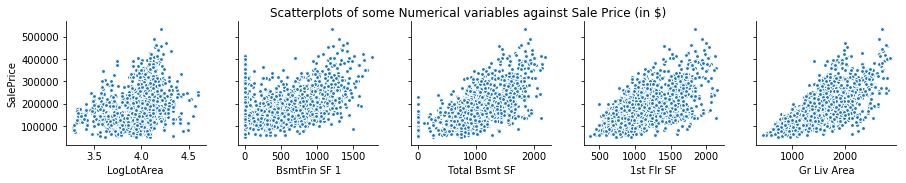

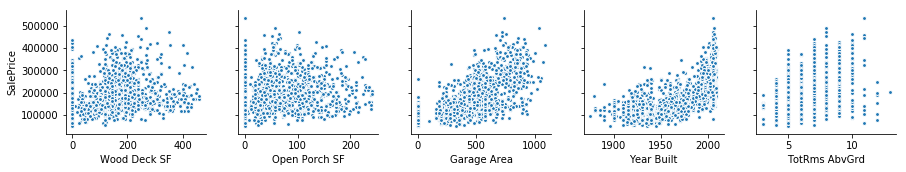

In [5]:
sns.pairplot(data, y_vars = 'SalePrice', x_vars = numerical_variables[1:6], plot_kws = {'s': 15})
plt.suptitle('Scatterplots of some Numerical variables against Sale Price (in $)').set_position([0.5, 1.0])
sns.pairplot(data, y_vars = 'SalePrice', x_vars = numerical_variables[6:11], plot_kws = {'s': 15})
plt.show()

After having dealt with the outliers, we see that some values are correlated with the Sale Price (like the Living Area above ground), whereas others far less ('Open Porch SF'). We also see that some variables could have polynomial growth, whereas others (like 'BsmtFin SF 1') have a far slower growth. For some variables, it is probably useful to include polynomial features.

# Modelling

We make now three models : a basic model using a numerical and a categorical variable, an intermediate model using all numerical and some important categorical variables and finally a complex model using all variables.

Root Mean Squared Logarithmic Error of our basic model:  0.08416612745816514
Mean Absolute Error of our baic model:  0.06170849294009816


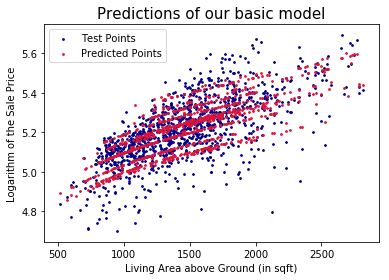

In [6]:
poly_obj = PolynomialFeatures(degree = 3, include_bias = False)
data_bas = pd.get_dummies(data[['Gr Liv Area', 'Neighborhood', 'LogSalePrice']], columns = ['Neighborhood'])
x_bas = data_bas.drop('LogSalePrice', axis = 1).values
y_bas = data_bas['LogSalePrice'].values
X_poly = poly_obj.fit_transform(x_bas[:, 0, np.newaxis])
X_bas = np.c_[X_poly, x_bas[:, 1:]]
X_tr_bas, X_te_bas, y_tr, y_te = train_test_split(X_bas, y_bas, 
                                                          train_size = 0.5, test_size = 0.5, random_state = 0)
lr = LinearRegression()
lr.fit(X_tr_bas, y_tr)
y_lr_bas = lr.predict(X_te_bas)

RMSE_bas = np.sqrt(mse(y_te, y_lr_bas))
print('Root Mean Squared Logarithmic Error of our basic model: ', RMSE_bas)
MAE_bas = mae(y_te, y_lr_bas)
print('Mean Absolute Error of our baic model: ', MAE_bas)

plt.scatter(X_te_bas[:, 0], y_te, s = 3, label = 'Test Points', color = 'darkblue')
plt.scatter(X_te_bas[:, 0], y_lr_bas, s = 3, label = 'Predicted Points', color = 'crimson')
plt.xlabel('Living Area above Ground (in sqft)')
plt.ylabel('Logarithm of the Sale Price')
plt.title('Predictions of our basic model', fontsize = 15)
plt.legend()
plt.show()

This model uses two variables : the Living Area above ground, that is in our opinion the most important variable, and the Neighbourhood, that is an interesting categorical variable. We used a linear regression with polynomial features of degree 3 and we see that it already captures more or less the trend of the data. We clearly see that the houses in some neighbourhoods have a greater average value that in others.

In [7]:
intermediate_variables = ['MS SubClass', 'MS Zoning', 'BsmtFin Type 1', 'Neighborhood', 'Sale Condition'] 
for column in numerical_variables :
    intermediate_variables.append(column)
data_int = data[intermediate_variables]
data_inter = pd.get_dummies(data_int, columns = data_int.columns.drop(numerical_variables))
data_int_tr, data_int_te = train_test_split(data_inter, train_size = 0.5, test_size = 0.5, random_state = 0)

def create_features(df):
    M = df.drop('LogSalePrice', axis = 1).values
    for column in numerical_variables[1:]:
        num_var = df[column].values
        M = np.c_[M, num_var ** 2, num_var ** 3]
    return(M) 

X_tr_int = create_features(data_int_tr)
X_te_int = create_features(data_int_te)
y_tr = data_int_tr['LogSalePrice'].values
y_te = data_int_te['LogSalePrice'].values

RMSLE of our intermediate model with linear regression:  0.061463065045626944
MAE of our intermediate model with linear regression:  0.04297595195374445
RMSLE of our intermediate model with ridge regression:  0.06138812683274201
MAE of our intermediate model with ridge regression:  0.042983992406128005


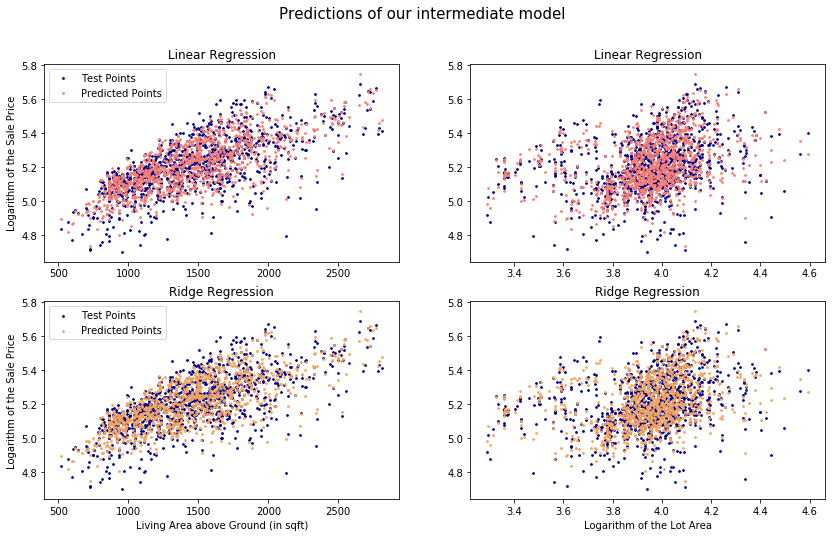

In [8]:
lr.fit(X_tr_int, y_tr)
y_lr_int = lr.predict(X_te_int)

ridge_int = Ridge(alpha = 0.547) # This value has been obtained using the grid search algorithm.
ridge_int.fit(X_tr_int, y_tr)
y_ridge_int = ridge_int.predict(X_te_int)

RMSLE_int_lr = np.sqrt(mse(y_te, y_lr_int))
print('RMSLE of our intermediate model with linear regression: ', RMSLE_int_lr)
MAE_int_lr = mae(y_te, y_lr_int)
print('MAE of our intermediate model with linear regression: ', MAE_int_lr)
RMSLE_int_ridge = np.sqrt(mse(y_te, y_ridge_int))
print('RMSLE of our intermediate model with ridge regression: ', RMSLE_int_ridge)
MAE_int_ridge = mae(y_te, y_ridge_int)
print('MAE of our intermediate model with ridge regression: ', MAE_int_ridge)

fig, (ax1, ax2) = plt.subplots(2, 2, figsize = (14, 8))
ax1[0].scatter(X_te_int[:, 4], y_te, s = 3, label = 'Test Points', color = 'darkblue')
ax1[0].scatter(X_te_int[:, 4], y_lr_int, s = 3, label = 'Predicted Points', color = 'salmon')
ax1[1].scatter(X_te_int[:, 0], y_te, s = 3, label = 'Test Points', color = 'darkblue')
ax1[1].scatter(X_te_int[:, 0], y_lr_int, s = 3, label = 'Predicted Points', color = 'salmon')
ax2[0].scatter(X_te_int[:, 4], y_te, s = 3, label = 'Test Points', color = 'darkblue')
ax2[0].scatter(X_te_int[:, 4], y_ridge_int, s = 3, label = 'Predicted Points', color = 'sandybrown')
ax2[1].scatter(X_te_int[:, 0], y_te, s = 3, label = 'Test Points', color = 'darkblue')
ax2[1].scatter(X_te_int[:, 0], y_ridge_int, s = 3, label = 'Predicted Points', color = 'sandybrown')
ax1[0].set_title('Linear Regression'), ax1[1].set_title('Linear Regression')
ax2[0].set_title('Ridge Regression'), ax2[1].set_title('Ridge Regression')
ax2[0].set_xlabel('Living Area above Ground (in sqft)')
ax1[0].set_ylabel('Logarithm of the Sale Price')
ax2[0].set_ylabel('Logarithm of the Sale Price')
ax2[1].set_xlabel('Logarithm of the Lot Area')
plt.suptitle('Predictions of our intermediate model', fontsize = 15)
ax1[0].legend(), ax2[0].legend()
plt.show()

Our model uses all numerical variables, and some important categorical variables, among them the Neighbourhood, the Sale Condition and a variable that corresponds more or less to the number of floors of the house. We see that our prediction already captures the trend quite well. We showed here the scatter plots of the Living Area above Ground and the Lot Area against the Sale Price using a linear and a ridge regression. The two models give similar predictions and we have to take a closer look in order to see a difference between the plots. The mean squared error shows us that the model using the ridge regression is slightly more performent indeed. We added polynomial features of degree 3 for all numerical variables and the parameter in the ridge regression has been optimised using a grid search.

RMSLE of our complex model with linear regression:  0.053588399077015396
MAE of our complex model with linear regression:  0.03641159389172852
RMSLE of our complex model with ridge regression:  0.04988464433740615
MAE of our complex model with ridge regression:  0.03400166867441749


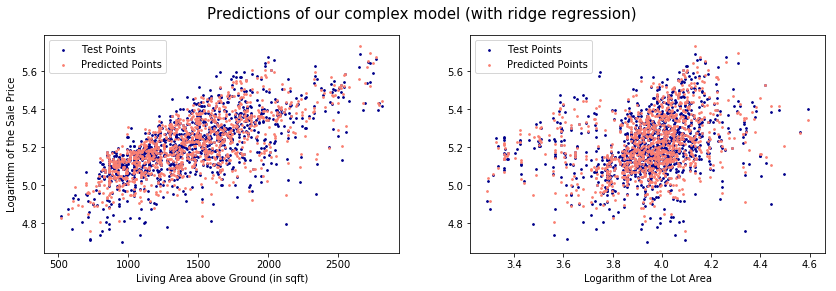

In [9]:
data_complex = data.drop(['SalePrice', 'Lot Area'], axis = 1)
data_comp = pd.get_dummies(data_complex, columns = data_complex.columns.drop(numerical_variables))
data_comp_tr, data_comp_te = train_test_split(data_comp, train_size = 0.5, test_size = 0.5, random_state = 0)

X_tr_comp = create_features(data_comp_tr)
X_te_comp = create_features(data_comp_te)

lr.fit(X_tr_comp, y_tr)
y_lr_comp = lr.predict(X_te_comp)

ridge_comp = Ridge(alpha = 4.168) # This value has been obtained using the grid search algorithm.
ridge_comp.fit(X_tr_comp, y_tr)
y_ridge_comp = ridge_comp.predict(X_te_comp)

RMSLE_comp_lr = np.sqrt(mse(y_te, y_lr_comp))
print('RMSLE of our complex model with linear regression: ', RMSLE_comp_lr)
MAE_comp_lr = mae(y_te, y_lr_comp)
print('MAE of our complex model with linear regression: ', MAE_comp_lr)
RMSLE_comp_ridge = np.sqrt(mse(y_te, y_ridge_comp))
print('RMSLE of our complex model with ridge regression: ', RMSLE_comp_ridge)
MAE_comp_ridge = mae(y_te, y_ridge_comp)
print('MAE of our complex model with ridge regression: ', MAE_comp_ridge)

fig, ax = plt.subplots(1, 2, figsize = (14, 4))
ax[0].scatter(X_te_comp[:, 4], y_te, s = 3, label = 'Test Points', color = 'darkblue')
ax[0].scatter(X_te_comp[:, 4], y_ridge_comp, s = 3, label = 'Predicted Points', color = 'salmon')
ax[1].scatter(X_te_comp[:, 10], y_te, s = 3, label = 'Test Points', color = 'darkblue')
ax[1].scatter(X_te_comp[:, 10], y_ridge_comp, s = 3, label = 'Predicted Points', color = 'salmon')
ax[0].set_xlabel('Living Area above Ground (in sqft)')
ax[0].set_ylabel('Logarithm of the Sale Price')
ax[0].set_ylabel('Logarithm of the Sale Price')
ax[1].set_xlabel('Logarithm of the Lot Area')
plt.suptitle('Predictions of our complex model (with ridge regression)', fontsize = 15)
ax[0].legend(), ax[1].legend()
plt.show()

This model uses all variables we did not drop in the data. We decided to plot only the model using the ridge regression, because the two plots would be very similar. The plot is still very similar to the one using the intermediate model, but the RMSLE and the MAE show us that this model improves significantly the predictions. This model should give good predictions for the sale price of the houses in Ames, at least when the data is similar to the one of other houses.

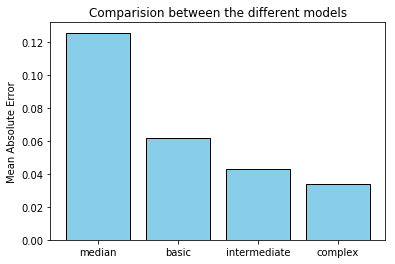

In [10]:
maes = [mae(y_te, np.median(y_tr) * np.ones(len(y_tr))), MAE_bas, MAE_int_ridge, MAE_comp_ridge]
plt.bar(np.arange(4), maes, edgecolor = 'black', color = 'skyblue')
plt.xticks(np.arange(4), ['median', 'basic', 'intermediate', 'complex'])
plt.ylabel('Mean Absolute Error')
plt.title('Comparision between the different models')
plt.show()

We see that the mean absolute error becomes smaller when the model contains more features. For the intermediate and the complex model, we used the model based on the ridge regression.

# Predictions

In [11]:
test_data = pd.read_csv('house-prices-test.csv')
test_data.set_index('PID', inplace = True)
test_data['LogLotArea'] = np.log10(test_data['Lot Area'])
for column in columns_missing_values :
    test_data[column].fillna(value = 'None', inplace = True)
test_data = test_data.reindex(columns = data.columns, fill_value = 0)

test_data_features = pd.get_dummies(test_data, columns = test_data.columns.drop(numerical_variables))
test_data_features = test_data_features.reindex(columns = data_comp.columns, fill_value = 0)
X = create_features(test_data_features)
predictions = 10 ** ridge_comp.predict(X)
predictions_df = pd.DataFrame.from_items([('PID', test_data.index), ('SalePrice', predictions)])

Here, we basically made the same preparation and data cleaning than for the original data frame (without dealing with the outliers, we come back to this later). We just had to be careful that our encoded data frame contains the same columns than the data frame of our complex model in order to be able to predict the data.

In [12]:
predictions_df['SalePrice'].describe()

count    5.000000e+02
mean     2.088147e+05
std      4.499092e+05
min      5.034029e+04
25%      1.296355e+05
50%      1.629108e+05
75%      2.160766e+05
max      9.924022e+06
Name: SalePrice, dtype: float64

In [13]:
original_data = pd.read_csv('house-prices.csv')
original_data['SalePrice'].describe()

count      2430.000000
mean     180199.692593
std       79607.467171
min       12789.000000
25%      129000.000000
50%      160000.000000
75%      213099.750000
max      755000.000000
Name: SalePrice, dtype: float64

Assuming that the 500 test houses have been chosen randomly, our predictions should have a similar distribution than our train data frame. Indeed, the distribution is quite similar, so the model gives probably an accurate estimation for most houses. However, we are not satisfied with the far higher standard deviation. We think that the problem lies in the fact that we did not considered the houses that had an outlier in one of the numerical variables. The model is too rigid, meaning that if a house does not have common values in a numerical variable, the model is not able to give an accurate estimation, leading to a very high standard deviation.

Indeed, a house that deals a lot of problems (PID : 908154205) has a living area of 4600 sqft, that is far higher than our standards. Hence, our model gives that house a very high Sale Price and it explains that our maximum value is far higher than it should be. And thus, the standard deviation becomes very high as well.

In retrospective, we probably should only ignore the houses that have an outlier in multiple columns in order to have a less rigid model. Ignoring the outlier issues completely gives a better standard deviation, but probably a worse prediction for normal houses. A potential fix would be using a Huber Regressor taking in account all the houses, but giving a lower weight to the outliers. 



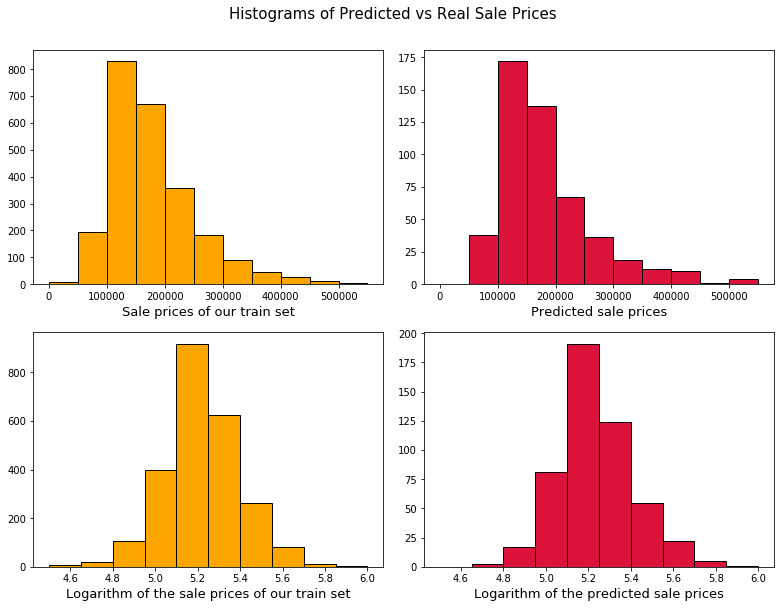

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize = (11, 8))
ax1[0].hist(original_data['SalePrice'], bins = 50000 * np.arange(12), color = 'orange', edgecolor = 'black')
ax2[0].hist(np.log10(original_data['SalePrice']), range = (4.5, 6), color = 'orange', edgecolor = 'black')
ax1[1].hist(predictions_df['SalePrice'], bins = 50000 * np.arange(12), color = 'crimson', edgecolor = 'black')
ax2[1].hist(ridge_comp.predict(X), range = (4.5, 6), color = 'crimson', edgecolor = 'black')
ax1[0].set_xlabel('Sale prices of our train set', fontsize = 13)
ax2[0].set_xlabel('Logarithm of the sale prices of our train set', fontsize = 13)
ax1[1].set_xlabel('Predicted sale prices', fontsize = 13)
ax2[1].set_xlabel('Logarithm of the predicted sale prices', fontsize = 13)
plt.suptitle('Histograms of Predicted vs Real Sale Prices', fontsize = 15).set_position([0.5, 1.05])
fig.tight_layout()
plt.show()

Here, we compare the histograms of our train and test data sets. We see that the distributions are very similar, so we think that the high standard deviation is probably not a big issue and that our model is satisfying for average houses, but very bad for outliers.